Reddit Sentiment Analysis - Trying to Beat the Market

Please see project description in the accompanying Github ReadMe file

# Import Libraries

In [ ]:
%%capture

#Import google colab
from google.colab import drive
drive.mount('/content/drive')

#Defaults
import pandas as pd
import numpy as np

#NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('opinion_lexicon')
nltk.download("vader_lexicon")

#Sentiment analysis
!pip install NRCLex
from nrclex import NRCLex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

#Emoji handling
!pip install emoji
import emoji

#Regex
import re

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
!pip install dexplot  
import dexplot as dxp
from termcolor import colored, cprint
import statsmodels.api as sm

#Datetime
from datetime import date, datetime

#Sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from collections import Counter


# Vectorization to get Bigrams and Trigrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Nltk for stemming
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, opinion_lexicon
from nltk.tokenize import word_tokenize

#Gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from collections import defaultdict

#Stock download
!pip install yfinance
import yfinance as yf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
#Function to implement the moving average strategy
def ma_strategy(df, signal_column, title_string):

  #Create empty lists
  LO_Returns = []
  LS_Returns = []
  index = []

  #Set counter
  counter = 0

  for i in df[signal_column]:
      if i == 1:
        try:
          LO_Returns.append(df['daily_return'][counter+1])
          LS_Returns.append(df['daily_return'][counter+1])
          index.append(df.index[counter+1])
        except: 
          pass  
      else: 
        try:
          #Append 0 for Long Only (not trading)
          LO_Returns.append(0)
          #Append short returns for LS (negative of return)
          ret = -df['daily_return'][counter+1]
          LS_Returns.append(ret)
          #Take date
          index.append(df.index[counter+1])
        except: 
          pass

      #Move counter
      counter+= 1

  #Turn into dataframe
  Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns)), columns=['LS_Return_Daily','LO_Return_Daily',], index=index)
  Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

  sns.set_style('darkgrid')
  dims = (20, 10)
  fig, ax = plt.subplots(figsize=dims)

  ax = sns.lineplot(data=Returns,
                    palette='rocket_r',
                    legend='full', lw=3.2, ax=ax)

  ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
  ax.set_xlabel('Date',fontsize=15);
  ax.set_ylabel('Daily Return (USD)',fontsize=14)
  ax.set_title(title_string, fontsize=20)
  plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

  #For adding colors to the results
  #Get summary stats
  str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['LO_Return_Daily'].mean()))
  str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['LS_Return_Daily'].mean()))
  str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['LO_Return_Daily'].sum()))
  str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['LS_Return_Daily'].sum()))
  str5 = ("Baseline Cumulative Return: $" + cum_return(df['daily_return']))

  numbers = [Returns['LO_Return_Daily'].mean(),Returns['LS_Return_Daily'].mean(),Returns['LO_Return_Daily'].sum(),Returns['LS_Return_Daily'].sum(),cum_return(df['daily_return'])]
  strings = [str1,str3,str2,str4,str5]
  counter = 0
  for i in numbers:
    j = strings[counter]
    if float(i) >= 0:
      print(colored(j, 'green', attrs=['bold']))
      counter +=1

    elif float(i) < 0:
      print(colored(j, 'red', attrs=['bold']))
      counter +=1

      #If I want to plot directly on graph can use below and adjust coordinates
  # ax.text(dt.date(2020, 4, 1), .42, str1, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .38, str3, fontsize=10,family='serif')
  # ax.text(dt.date(2020, 4, 1), .32, str2, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .28, str4, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .20, str5, fontsize=10, family='serif')


  plt.show()


#Simple function for getting cumulative return
def cum_return(data):
  d = data.sum()
  return "{:.2f}".format(d)

#Function to get basic countvectorizer ngrams
def get_ngrams(gram_name, corpus, ngram_range):
  vectorizer = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(ngram_range))
  cv_matrix = vectorizer.fit_transform(corpus)
  sparse = pd.DataFrame.sparse.from_spmatrix(cv_matrix, columns=vectorizer.get_feature_names())
  sums = sparse.sum(axis=0)
  sums = sums.sort_values(axis=0, ascending=False)
  ngrams = sums.to_frame()
  ngrams = ngrams.reset_index()
  ngrams = ngrams.rename(columns={"index": gram_name})
  return ngrams

#Remove stopwrods
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [ ]:
%%capture

#Import raw text data
df = pd.read_csv('/content/drive/MyDrive/Text_Mining/Reddit_WallStreetBets/reddit_wsb.csv')


#Create date column without seconds and years
df['Date'] = pd.to_datetime(df['timestamp']).dt.date
df['Date'] = pd.to_datetime(df['Date'])


#Set index to timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(df['timestamp'], drop=True).sort_index()

#Drop non text posts (links and pictures)
df = df.dropna(subset =['body'])

#Erroneous and irrelevant observation from September was included. Drop
df = df[1:]

#Download stock data
gme = yf.download('GME', 
                      start='2021-01-28', 
                      end='2021-08-17', 
                      progress=True)

gme = gme.reset_index()
gme['Date'] = pd.to_datetime(gme['Date'])

#Create copy for later use
gme_og = gme.copy()
df_og = df.copy()

### Data inspection

In [ ]:
#Note extremely high st.dev relative to the mean
df.describe()

,score,comms_num,created
count,24737.000000,24737.000000,2.473700e+04
mean,543.402110,401.852650,1.614242e+09
std,3509.302537,3364.177221,4.132066e+06
min,0.000000,0.000000,1.611818e+09
25%,1.000000,2.000000,1.611880e+09
50%,14.000000,14.000000,1.612432e+09
75%,107.000000,58.000000,1.614562e+09
max,111559.000000,93268.000000,1.629095e+09


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


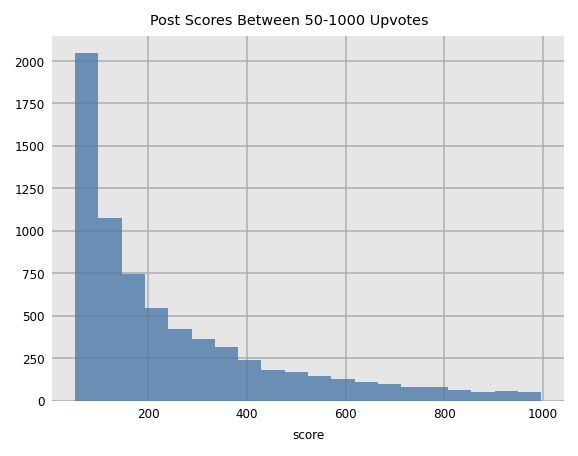

In [ ]:
#Analyze scores around the mean
df_ = df[df['score'] < 1000]
df_ = df_[df_['score'] > 50]
dxp.hist(val='score', data = df_, title='Post Scores Between 50-1000 Upvotes')

### Preprocessing

In [ ]:
%%capture
#remove posts that have less than 50 upvotes (these won't be seen by many in the community)
df = df[df['score'] >= 50]

#Remove hyperlinks 

df["body"] = df["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")
df["title"] = df["title"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

#Combine title and body to create corpus
df['corpus'] = df['title'] + df['body']

In [ ]:
#Copy checkpoint
#dfcopy = df.copy()
df = dfcopy.copy()

#Groupby drops the text, so use below to save the text
txtday = dfcopy.groupby(['Date'])['corpus'].apply(lambda x: ','.join(x)).reset_index()

#Now groupby date
df = df.groupby(by=['Date']).sum()

#Add groupby text into new daily dataframe
df['corpus'] = txtday['corpus'].values

#Turn weekends into friday and groupby so we only have data for trading days
#Rational is all Friday+weekend information will be used to make trading strategy on next Monday

#Get day of week from datetime
df['Weekday'] = df.index.weekday

#Reset index to get Date column as regular column
df.reset_index(inplace=True)

#For loops to change dates associated with Saturdays and Sundays to Fridays
counter = 0
for i in df['Date']:
    if df['Weekday'][counter] == 5:
      b = df['Date'][counter-1]
      df = df.replace(i,b)
    counter+=1


counter=0
for i in df['Date']:
    if df['Weekday'][counter] == 6:
      b = df['Date'][counter-2]
      df = df.replace(i,b)
    counter+=1

#Replace Saturdays and Sundays as Friday
df['Weekday'] = df['Weekday'].replace(5,4)
df['Weekday'] = df['Weekday'].replace(6,4)


In [ ]:
#Now extract corpus for Groupby again
txtday = df.groupby(['Date'])['corpus'].apply(lambda x: ','.join(x)).reset_index()

#Groupby date and merge corpus
df = df.groupby(by=['Date']).sum()
df['corpus'] = txtday['corpus'].values

#Filter desired features
df = (df.filter(items=['score', 'comms_num', 'corpus']))

In [ ]:
#Demojize text
counter = 0
for i in df['corpus']:
  e = emoji.demojize(str(i))
  df['corpus'][counter] = df['corpus'][counter].replace(i, e)
  counter+=1

#Get all posts as one document for analysis
posts = [' '.join(df['corpus'])]
tfidfposts = df['corpus']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## N-Grams / Vectorizer

In [ ]:
#Get unigrams, bigrams, and trigrams using function to do raw inspection
# unigrams = get_ngrams(("unigrams"), tfidfposts, (1,1))
# bigrams = get_ngrams(("bigrams"), tfidfposts, (2,2))
# trigrams = get_ngrams(("trigram"), tfidfposts, (3,3))
# grams = pd.concat([unigrams, bigrams, trigrams], axis=1)
# grams = grams.rename(columns={0: "Count"})
# grams.head(25)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,unigrams,Count,bigrams,Count,trigram,Count
0,rocket,14928.0,rocket rocket,10959.0,rocket rocket rocket,9100
1,stock,11398.0,hedge funds,1785.0,daily best weekly,1325
2,gme,10913.0,best daily,1590.0,best daily best,1325
3,shares,10608.0,financial advice,1339.0,orangutan orangutan orangutan,455
4,market,10585.0,best weekly,1325.0,gorilla gorilla gorilla,284
5,price,10066.0,daily best,1325.0,best weekly loss,266
6,short,9650.0,short squeeze,1174.0,gain best daily,265
7,just,9559.0,long term,1160.0,loss best daily,265
8,like,8885.0,market cap,1064.0,weekly yolo best,265
9,x200b,7532.0,stock price,926.0,daily dd dd,265


Can see above that daily threads are far more popular. A TFIDF would be more appropriate.

In [ ]:
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(tfidfposts)
# tf = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf = tf.sort_values('TF-IDF', ascending=False)
# print('Unigrams: ', tf.head(25))
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
# Y = vectorizer.fit_transform(posts)
# tf2 = pd.DataFrame(Y[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf2 = tf2.sort_values('TF-IDF', ascending=False)
# print('Bigrams: ', tf2.head(25))
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(3,3))
# Z = vectorizer.fit_transform(posts)
# tf3 = pd.DataFrame(Z[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf3 = tf3.sort_values('TF-IDF', ascending=False)

# print('Trigrams: ', tf3.head(25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Unigrams:                             TF-IDF
rocket                   0.345861
smiling_face_with_horns  0.304752
gme                      0.265571
short                    0.173894
cold_face                0.157937
market                   0.152786
shares                   0.150646
like                     0.138393
price                    0.136140
stock                    0.130560
just                     0.127322
people                   0.121786
know                     0.116971
don                      0.113597
silver                   0.111671
melvin                   0.107035
sell                     0.097887
hedge                    0.093561
money                    0.088853
going                    0.088422
nok                      0.088022
buy                      0.083692
time                     0.083036
ve                       0.079353
wsb                      0.073649


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Bigrams:                             TF-IDF
rocket rocket            0.847872
hedge funds              0.138101
best daily               0.123015
financial advice         0.103595
best weekly              0.102512
daily best               0.102512
short squeeze            0.090830
long term                0.089747
market cap               0.082319
stock price              0.071642
tl dr                    0.066072
x200b x200b              0.065763
don know                 0.064911
wall street              0.062436
share price              0.060734
like stock               0.057252
stock market             0.057020
hedge fund               0.052455
short term               0.052223
retail investors         0.050908
discussion thread        0.049128
financial advisor        0.048200
gamma squeeze            0.047581
make money               0.045260
gem_stone raising_hands  0.044641


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Trigrams:                                   TF-IDF
rocket rocket rocket           0.945518
daily best weekly              0.137672
best daily best                0.137672
orangutan orangutan orangutan  0.047276
gorilla gorilla gorilla        0.029508
best weekly loss               0.027638
navigate wsb recommend         0.027534
weekly gain best               0.027534
weekly discussion best         0.027534
best weekly discussion         0.027534
best weekly gain               0.027534
discussion best daily          0.027534
best weekly yolo               0.027534
yolo best daily                0.027534
best daily dd                  0.027534
wsb recommend best             0.027534
gain best daily                0.027534
recommend best daily           0.027534
weekly loss best               0.027534
dd dd best                     0.027534
weekly yolo best               0.027534
daily dd dd                    0.027534
dd best daily                  0.027534
loss best daily              

The rocketship emoji is by far the most popular piece of text - the TF-IDF scores are through the roof. Let's filter to GameStop and inspect further

In [ ]:
#Try with filtered data to see if results are different

# df2 = df[df['corpus'].str.contains("gamestop|gme|game|gmstop|gm|gms", case=False)]

# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(df2['corpus'])
# tf = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf = tf.sort_values('TF-IDF', ascending=False)
# print('Unigrams: ', tf.head(10))
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
# Y = vectorizer.fit_transform(posts)
# tf2 = pd.DataFrame(Y[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf2 = tf2.sort_values('TF-IDF', ascending=False)
# print('Bigrams: ', tf2.head(10))
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(3,3))
# Z = vectorizer.fit_transform(posts)
# tf3 = pd.DataFrame(Z[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
# tf3 = tf3.sort_values('TF-IDF', ascending=False)

# print('Trigrams: ', tf3.head(10))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Unigrams:                             TF-IDF
rocket                   0.348712
smiling_face_with_horns  0.305005
gme                      0.261253
short                    0.173785
cold_face                0.158113
market                   0.153781
shares                   0.151656
like                     0.139295
price                    0.137052
stock                    0.131435


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Bigrams:                      TF-IDF
rocket rocket     0.847872
hedge funds       0.138101
best daily        0.123015
financial advice  0.103595
best weekly       0.102512
daily best        0.102512
short squeeze     0.090830
long term         0.089747
market cap        0.082319
stock price       0.071642


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Trigrams:                                   TF-IDF
rocket rocket rocket           0.945518
daily best weekly              0.137672
best daily best                0.137672
orangutan orangutan orangutan  0.047276
gorilla gorilla gorilla        0.029508
best weekly loss               0.027638
navigate wsb recommend         0.027534
weekly gain best               0.027534
weekly discussion best         0.027534
best weekly discussion         0.027534


## Sentiment Analysis

#### Vader Library

In [ ]:
# analyzer = SentimentIntensityAnalyzer()

# df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['corpus']]
# df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['corpus']]
# df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['corpus']]
# df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['corpus']]

In [ ]:
sid = SentimentIntensityAnalyzer()

sidlist = []
df['scores'] = df['corpus'].apply(lambda sentiment: sid.polarity_scores(sentiment))

df.head()

,score,comms_num,corpus,scores
Date,,,,
2021-01-28,563382,134024,I got in late on GME but I believe in the caus...,"{'neg': 0.11, 'neu': 0.771, 'pos': 0.119, 'com..."
2021-01-29,3362721,955325,IF YOU BOUGHT $AMC FUCKING HOLDIGNORE THE DIP ...,"{'neg': 0.093, 'neu': 0.777, 'pos': 0.13, 'com..."
2021-02-01,749815,242527,My diamond hands are shakingI am truly an ape....,"{'neg': 0.086, 'neu': 0.788, 'pos': 0.126, 'co..."
2021-02-02,443378,50580,Financial News sites that are Not listed?All o...,"{'neg': 0.095, 'neu': 0.777, 'pos': 0.129, 'co..."
2021-02-03,687556,188422,NOK Announces 10G rollout at 9AM. Its gonna be...,"{'neg': 0.097, 'neu': 0.769, 'pos': 0.134, 'co..."


In [ ]:
vs['compound'].sort_values()

Date
2021-07-20   -0.9998
2021-05-20   -0.9596
2021-07-12   -0.8946
2021-05-25   -0.8498
2021-08-10   -0.4118
               ...  
2021-03-15    1.0000
2021-03-16    1.0000
2021-04-29    1.0000
2021-03-11    1.0000
2021-05-28    1.0000
Name: compound, Length: 126, dtype: float64

In [ ]:
df['score'].sort_values().head(25)

Date
2021-07-20       9
2021-08-16      13
2021-08-10      33
2021-05-05     108
2021-08-02     228
2021-05-25     303
2021-07-19     356
2021-05-21     403
2021-05-13     485
2021-08-05     566
2021-07-05     618
2021-07-14     643
2021-04-30     698
2021-05-11     730
2021-04-22     796
2021-05-20     831
2021-06-30     848
2021-05-19     853
2021-05-17     933
2021-08-04     961
2021-07-12     971
2021-04-21     972
2021-08-09    1028
2021-05-31    1047
2021-07-01    1115
Name: score, dtype: int64

#### NRC Library

In [ ]:
NRC_emotion_list = []

for i in df['corpus']:
  emotion = NRCLex(i)
  NRC_emotion_list.append(emotion.affect_frequencies)


nrc_df = pd.DataFrame(NRC_emotion_list)

#Create rolling averages of emotions for visualization purposes
columns = ['Positive', 'Negative' , 'Trust' , 'Fear', 'Anticipation', 'Anger', 'Joy', 'Sadness', 'Surprise','Disgust']
for emotion in nrc_df:
    nrc_df[emotion+"Rolling Average"] = nrc_df[emotion].rolling(3).mean()
#Reorder columns for plotting
columns = ['positive_rollingavg', 'negative_rollingavg' , 'trust_rollingavg' , 'fear_rollingavg', 'anticipation_rollingavg', 'anger_rollingavg', 'joy_rollingavg', 'sadness_rollingavg', 'surprise_rollingavg','disgust_rollingavg']
cols = nrc_df.iloc[:,-10:-1].columns
nrc_df.drop(columns='anticip', axis=1, inplace=True)

In [ ]:
nrc_df

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,...,Anger,Anticipation,Trust,Surprise,Positive,Negative,Sadness,Disgust,Joy,Anticipation 2
0,0.086120,0.084197,0.131844,0.045724,0.199319,0.161142,0.059041,0.045428,0.072655,0.114531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.081309,0.080570,0.146898,0.049440,0.195022,0.153838,0.064220,0.037386,0.073630,0.117687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.081078,0.074069,0.143702,0.050151,0.201890,0.159198,0.063203,0.035234,0.070083,0.121391,...,0.079612,0.0,0.140815,0.048438,0.198744,0.158059,0.062155,0.039349,0.072123,0.117870
3,0.078812,0.073746,0.152302,0.044184,0.209119,0.157496,0.062909,0.037963,0.068360,0.115108,...,0.076129,0.0,0.147634,0.047925,0.202011,0.156844,0.063444,0.036861,0.070691,0.118062
4,0.078591,0.074464,0.144075,0.048025,0.204072,0.148701,0.065575,0.036914,0.078092,0.121491,...,0.074093,0.0,0.146693,0.047453,0.205027,0.155132,0.063896,0.036704,0.072178,0.119330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.078362,0.059662,0.132680,0.052538,0.237756,0.140695,0.045414,0.021371,0.082814,0.148709,...,0.061324,0.0,0.149502,0.053686,0.250234,0.132236,0.047049,0.025465,0.077163,0.134012
122,0.064399,0.047995,0.154921,0.055893,0.257594,0.134265,0.052248,0.018226,0.075942,0.138518,...,0.056061,0.0,0.151569,0.055003,0.250424,0.133101,0.047466,0.023068,0.076164,0.137190
123,0.062259,0.053444,0.174656,0.041873,0.298623,0.095317,0.039118,0.012672,0.073829,0.148209,...,0.053700,0.0,0.154086,0.050101,0.264658,0.123425,0.045593,0.017423,0.077528,0.145145
124,0.057405,0.059783,0.152514,0.049592,0.244226,0.131454,0.049592,0.022418,0.083899,0.149117,...,0.053740,0.0,0.160697,0.049120,0.266814,0.120345,0.046986,0.017772,0.077890,0.145281


In [ ]:
nrc_df.rename(columns = {'fearRolling Average' : 'Fear',
       'angerRolling Average' : 'Anger', 'anticipRolling Average' : 'Anticipation',
       'trustRolling Average' : 'Trust', 'surpriseRolling Average' :'Surprise',
       'positiveRolling Average' :'Positive', 'negativeRolling Average' :'Negative',
       'sadnessRolling Average' :'Sadness', 'disgustRolling Average' :'Disgust',
       'joyRolling Average' :'Joy', 'anticipationRolling Average' :'Anticipation 2'}, inplace=True)

#Take only last 10 columns and drop the last one (duplicate of anticipation)
cols = nrc_df.iloc[:,0:10].columns

fig = px.line(nrc_df, x=df.index, y=cols,
             # hover_data={"Date"},
              title='Reddit Post Emotion Scores Each Trading Period as Classified by NRC'
              )
fig.update_xaxes(rangeslider_visible=False,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="NRC Emotion Score", xaxis_title="Date")
fig.show()

### Make Predictions Based on Sentiment Scores

In [ ]:
#Merge sentiment scores to finance stock 
gme = gme_og.copy()
gme.set_index('Date', inplace=True)
nrc_df.set_index(df.index, inplace=True)
nrc_df = nrc_df.iloc[:,0:10]
nrc_df['Buy'] = nrc_df['trust'] + nrc_df['positive'] + nrc_df['joy'] + nrc_df['anticipation'] 
nrc_df['Sell'] = nrc_df['anger'] + nrc_df['negative'] + nrc_df['disgust'] + nrc_df['sadness'] + nrc_df['sadness'] 
gme  = pd.concat([gme, nrc_df], ignore_index=False, axis=1)

I have holidays that were not inlucded in the financial data. Do not want to lose weekend worth of sentiment, so filling those missing values with average of observations before and after using shift method

In [ ]:
gme.Close = gme.Close.fillna((gme.Close.shift() + gme.Close.shift(-1))/2)

#Create daily returns
gme['daily_return'] = (gme.Close - gme.Open)
gme['daily_return_pct_change'] = gme['daily_return'].pct_change(periods = 1)
gme['Buy_chg'] = gme['Buy'].pct_change(periods = 1)
gme['Sell_chg'] = gme['Sell'].pct_change(periods = 1)

#Filter wanted items
#gmecopy=gme.copy()
gme = gme.filter(items = ['Close', 'Buy','Sell', 'Buy_chg', 'Sell_chg', 'daily_return', 'daily_return_pct_change'])

g = gme.copy()

### Baseline - Dual Moving Average

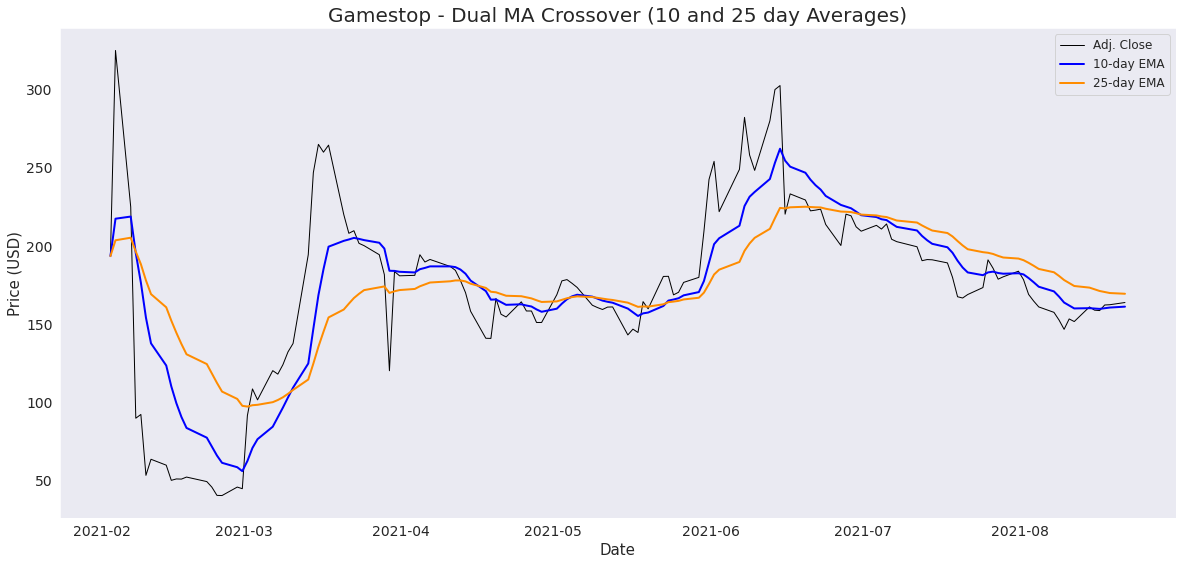

In [ ]:
gme = gme_og.copy()
#Create daily returns
gme['daily_return'] = (gme.Close - gme.Open)
gme['daily_return_pct_change'] = gme['daily_return'].pct_change(periods = 1)
# Create 20 days exponential moving average column
gme['EMA_10'] = gme['Close'].ewm(span = 10, adjust = False).mean()
# Create 50 days exponential moving average column
gme['EMA_25'] = gme['Close'].ewm(span = 25, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 5-day EMA then set Signal as 0 else 1
  
gme['Signal'] = 0.0  
gme['Signal'] = np.where(gme['EMA_10'] > gme['EMA_25'], 1.0, 0.0)
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
gme['Position'] = gme['Signal'].diff()
plt.figure(figsize = (20,10))
# plot Close, short-term and long-term moving averages 
gme['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
gme['EMA_10'].plot(color = 'b', lw = 2, label = '10-day EMA') 
gme['EMA_25'].plot(color = 'darkorange', lw = 2, label = '25-day EMA')

#plot 'buy' and 'sell' signals. 
# plt.plot(gme[gme['Position'] == 1].index, 
#          gme['EMA_10'][gme['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(gme[gme['Position'] == -1].index, 
#          gme['EMA_10'][gme['Position'] == -1], 
 #        'v', markersize = 15, color = 'r', label = 'sell')

plt.ylabel('Price (USD)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Gamestop - Dual MA Crossover (10 and 25 day Averages)', fontsize = 20)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.show()

LO Mean Returns: $-1.48
LS Mean Returns: $-0.77
LO Cumulative Returns: $-204.76
LS Cumulative Returns: $-106.70
Baseline Cumulative Return: $-374.22


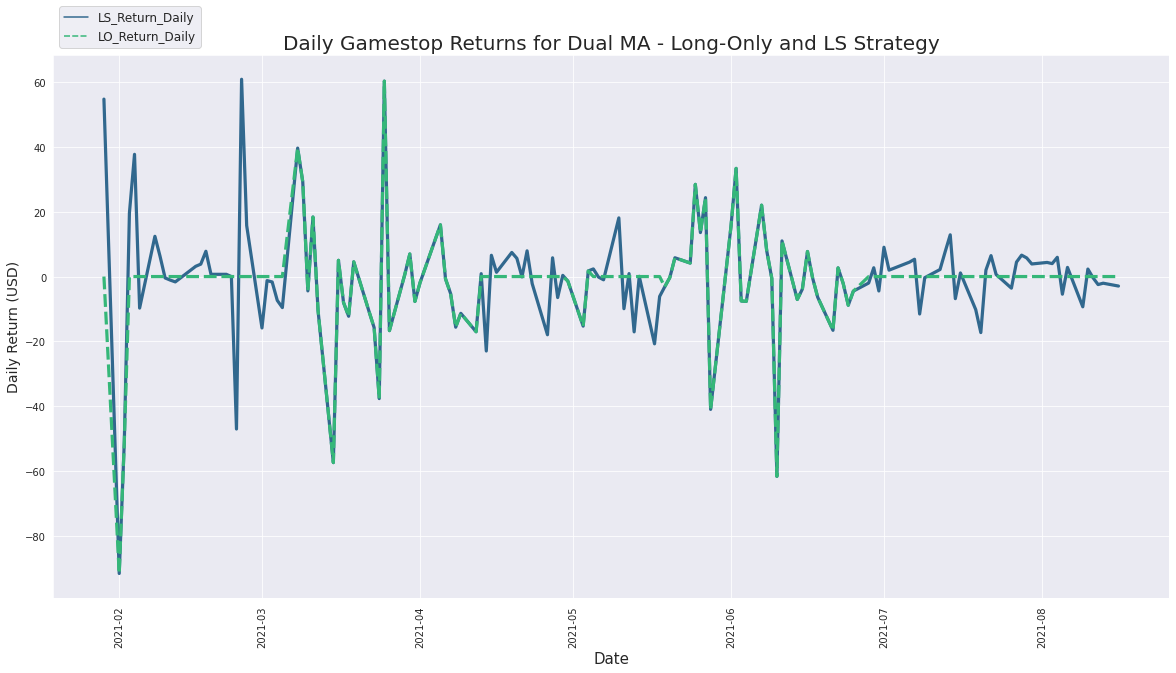

In [ ]:
ma_strategy(gme, 'Signal', "Daily Gamestop Returns for Dual MA - Long-Only and LS Strategy")

Because positivity is overweighted, I want to look at percentage changes instead of raw negativity vs positivity scores

In [ ]:
#Create sentiment signals
g['sentiment_signal'] = np.where(g['Sell_chg'] < g['Buy_chg'], 1.0, 0.0)

LO Mean Returns: $-0.90
LS Mean Returns: $0.37
LO Cumulative Returns: $-126.20
LS Cumulative Returns: $50.42
Baseline Cumulative Return: $-374.22


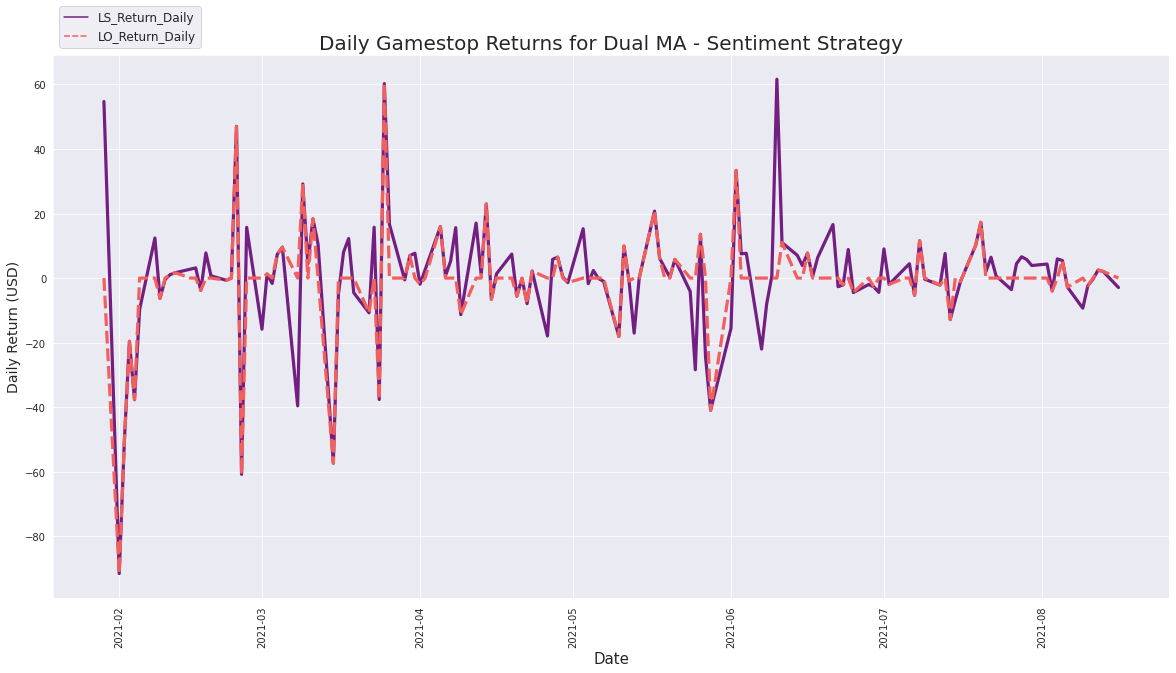

In [ ]:
ma_strategy(g, 'sentiment_signal', "Daily Gamestop Returns for Dual MA - Sentiment Strategy")

In [ ]:
#Create sentiment signals
g['sentiment_signal_buysell'] = np.where(g['Sell'] < g['Buy'], 1.0, 0.0)

# Gamestop Filtered Text

Now we filter the data to only posts that include Gamestop

### Preprocess

In [ ]:
df = df_og.copy()

#Did not filter upvotes so that can have a full schedule of days

#Remove hyperlinks 

df["body"] = df["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")
df["title"] = df["title"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

#Combine title and body to create corpus
df['corpus'] = df['title'] + df['body']

df = df[df['corpus'].str.contains("gamestop|gme|game|gmstop|gm|gms|games", case=False)]

txtday = df.groupby(['Date'])['corpus'].apply(lambda x: ','.join(x)).reset_index()
df = df.groupby(by=['Date']).sum()
df['corpus'] = txtday['corpus'].values
#Turn weekends into friday and groupby so we only have data for trading days
df['Weekday'] = df.index.weekday
df.reset_index(inplace=True)
df2 = df.copy()


counter = 0
for i in df['Date']:
    if df['Weekday'][counter] == 5:
      b = df['Date'][counter-1]
      df = df.replace(i,b)
    counter+=1


counter=0
for i in df['Date']:
    if df['Weekday'][counter] == 6:
      b = df['Date'][counter-2]
      df = df.replace(i,b)
    counter+=1


df['Weekday'] = df['Weekday'].replace(5,4)
df['Weekday'] = df['Weekday'].replace(6,4)

txtday = df.groupby(['Date'])['corpus'].apply(lambda x: ','.join(x)).reset_index()
df = df.groupby(by=['Date']).sum()
df['corpus'] = txtday['corpus'].values
#Filter
df = (df.filter(items=['score', 'comms_num', 'corpus']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

The default value of regex will change from True to False in a future version.



### NRC Sentiment

In [ ]:
NRC_emotion_list = []

for i in df['corpus']:
  emotion = NRCLex(i)
  NRC_emotion_list.append(emotion.affect_frequencies)


nrc_df = pd.DataFrame(NRC_emotion_list)

#Create rolling averages of emotions for visualization purposes
columns = ['Positive', 'Negative' , 'Trust' , 'Fear', 'Anticipation', 'Anger', 'Joy', 'Sadness', 'Surprise','Disgust']
for emotion in nrc_df:
    nrc_df[emotion+"Rolling Average"] = nrc_df[emotion].rolling(3).mean()
#Reorder columns for plotting
columns = ['positive_rollingavg', 'negative_rollingavg' , 'trust_rollingavg' , 'fear_rollingavg', 'anticipation_rollingavg', 'anger_rollingavg', 'joy_rollingavg', 'sadness_rollingavg', 'surprise_rollingavg','disgust_rollingavg']
cols = nrc_df.iloc[:,-10:-1].columns

nrc_df.drop(columns='anticip', axis=1, inplace=True)

nrc_df.rename(columns = {'fearRolling Average' : 'Fear',
       'angerRolling Average' : 'Anger', 'anticipRolling Average' : 'Anticipation',
       'trustRolling Average' : 'Trust', 'surpriseRolling Average' :'Surprise',
       'positiveRolling Average' :'Positive', 'negativeRolling Average' :'Negative',
       'sadnessRolling Average' :'Sadness', 'disgustRolling Average' :'Disgust',
       'joyRolling Average' :'Joy', 'anticipationRolling Average' :'Anticipation 2'}, inplace=True)

#Take only last 10 columns and drop the last one (duplicate of anticipation)
cols = nrc_df.iloc[:,0:10].columns

fig = px.line(nrc_df, x=df.index, y=cols,
             # hover_data={"Date"},
              title='Reddit Gamestop Post Emotion Scores - Trading Period as Classified by NRC'
              )
fig.update_xaxes(rangeslider_visible=False,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="NRC Emotion Score", xaxis_title="Date")
fig.show()

In [ ]:
nr = nrc_df.iloc[:,0:10]

In [ ]:
nr.set_index(df.index, inplace=True)

In [ ]:
df = pd.concat([df, nr], axis=1)

### Vader Sentiment

In [ ]:
#Run sentiment analysis

analyzer = SentimentIntensityAnalyzer()

df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['corpus']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['corpus']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['corpus']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['corpus']]

In [ ]:
#vs = pd.read_csv("/content/VADER_Scores2.csv")

In [ ]:
vs.set_index("Date", inplace=True)
v = vs.iloc[:,-4:]

In [ ]:
gm=gme_og.merge(df, how='right', on='Date')
gm['compound'] = v['compound'].values
gm['neg'] = v['neg'].values
gm['neu'] = v['neu'].values
gm['pos'] = v['pos'].values

d = gm.filter(['Close','Volume', 'Open', 'daily_return', 'daily_return_pct_change', 'sentiment_signal',
       'comms_num', 'corpus', 'compound', 'neg', 'neu', 'pos', 'fear', 'anger',
       'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust',
       'joy', 'anticipation'])
d.set_index(gm.Date, inplace=True)
sentiments = gm.filter(['compound', 'neg', 'neu', 'pos', 'fear', 'anger',
       'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust',
       'joy', 'anticipation'])

In [ ]:
fig = px.line(df.iloc[:,3:], x=df.index, y=df.iloc[:,3:].columns,
             # hover_data={"Date"},
              title='Reddit Gamestop Post Sentiment Scores - Trading Period as Classified by VADER'
              )
fig.update_xaxes(rangeslider_visible=False,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="VADER Sentiment Score", xaxis_title="Date")
fig.show()

### Combined Sentiment

In [ ]:
fig = px.line(sentiments, x=sentiments.index, y=sentiments.columns,
             # hover_data={"Date"},
              title='Reddit Gamestop Post Sentiment Scores - Combined'
              )
fig.update_xaxes(rangeslider_visible=False,
    #dtick="M1",
    tickformat="%b\n%d")
fig.update_layout(yaxis_range=[-.5,.5])
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="Sentiment Score", xaxis_title="Date")
fig.show()

## Trading

### DMA

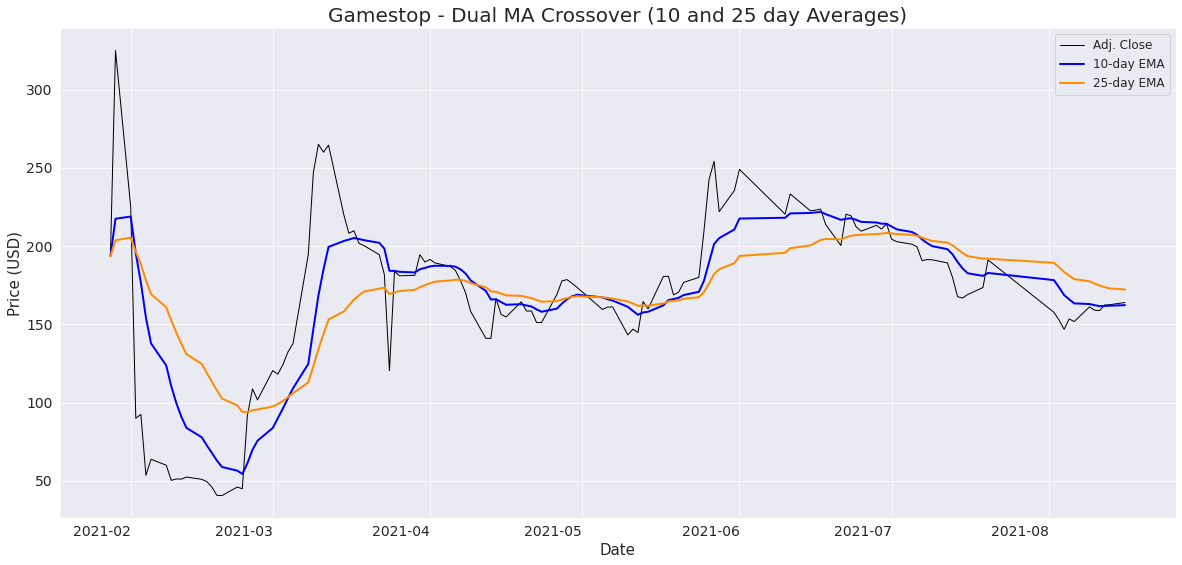

In [ ]:
gme = d.copy()
gme.Close = gme.Close.fillna((gme.Close.shift() + gme.Close.shift(-1))/2)

#Create daily returns
gme['daily_return'] = (gme.Close - gme.Open)
gme['daily_return_pct_change'] = gme['daily_return'].pct_change(periods = 1)
gme['EMA_10'] = gme['Close'].ewm(span = 10, adjust = False).mean()
# Create 50 days exponential moving average column
gme['EMA_25'] = gme['Close'].ewm(span = 25, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 5-day EMA then set Signal as 0 else 1
  
gme['Signal'] = 0.0  
gme['Signal'] = np.where(gme['EMA_10'] > gme['EMA_25'], 1.0, 0.0)
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
gme['Position'] = gme['Signal'].diff()
plt.figure(figsize = (20,10))
# plot Close, short-term and long-term moving averages 
gme['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
gme['EMA_10'].plot(color = 'b', lw = 2, label = '10-day EMA') 
gme['EMA_25'].plot(color = 'darkorange', lw = 2, label = '25-day EMA')

#plot 'buy' and 'sell' signals. 
# plt.plot(gme[gme['Position'] == 1].index, 
#          gme['EMA_10'][gme['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(gme[gme['Position'] == -1].index, 
#          gme['EMA_10'][gme['Position'] == -1], 
 #        'v', markersize = 15, color = 'r', label = 'sell')

plt.ylabel('Price (USD)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Gamestop - Dual MA Crossover (10 and 25 day Averages)', fontsize = 20)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.show()

LO Mean Returns: $-2.06
LS Mean Returns: $-1.64
LO Cumulative Returns: $-251.16
LS Cumulative Returns: $-198.67
Baseline Cumulative Return: $-375.05


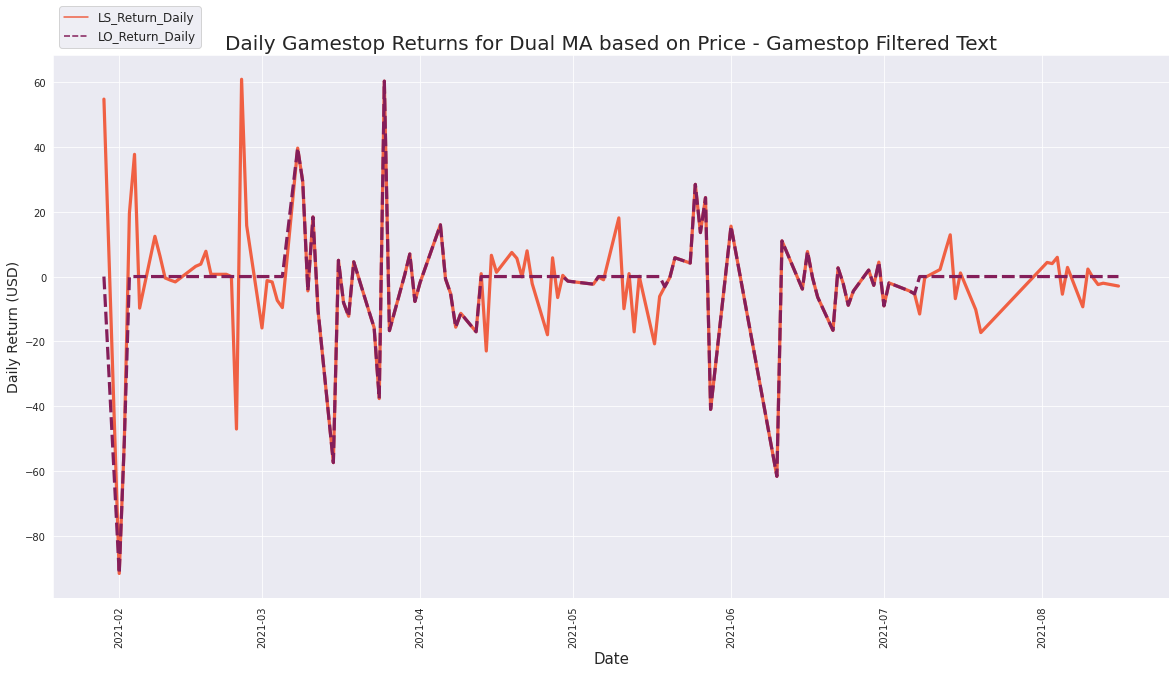

In [ ]:
ma_strategy(gme, 'Signal', "Daily Gamestop Returns for Dual MA based on Price - Gamestop Filtered Text")

### NRC

LO Mean Returns: $-0.63
LS Mean Returns: $1.23
LO Cumulative Returns: $-77.56
LS Cumulative Returns: $148.53
Baseline Cumulative Return: $-375.05


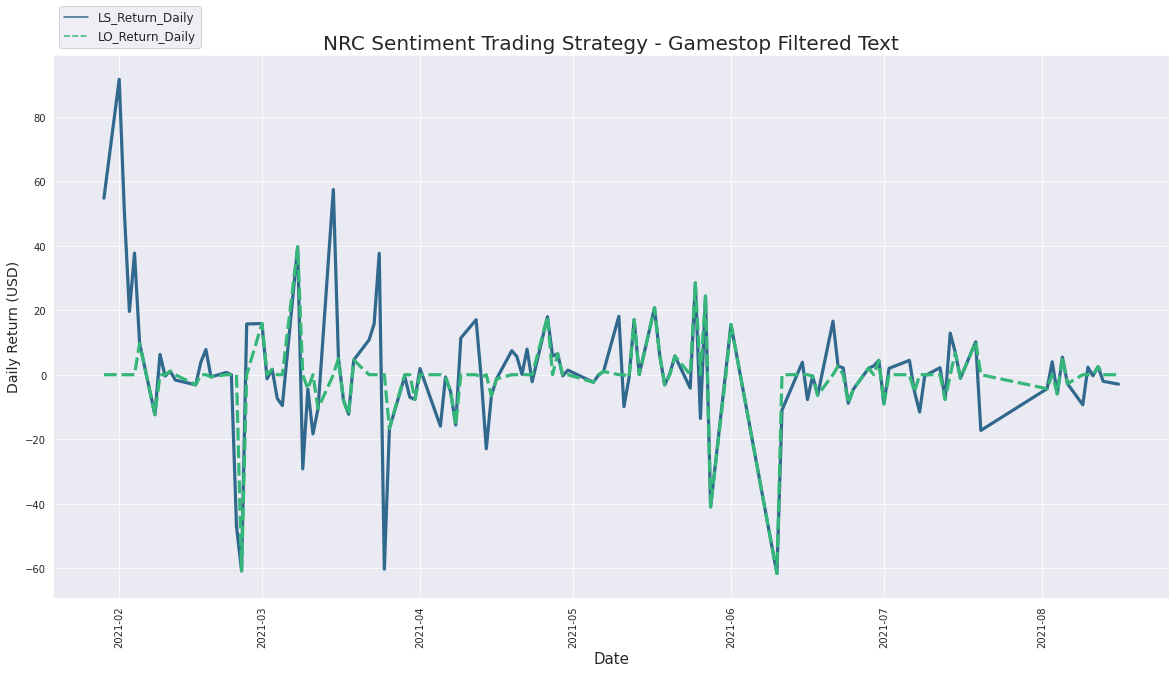

In [ ]:
sentiments.set_index(v.index, inplace=True)
sentiments['daily_return'] = (gm['Close'].values - gm['Open'].values)

sentiments['Buy'] = sentiments['trust'] + sentiments['positive'] + sentiments['joy'] + sentiments['anticipation'] 
sentiments['Sell'] = sentiments['anger'] + sentiments['negative'] + sentiments['disgust'] + sentiments['sadness']  
sentiments['Sell_chg'] = sentiments['Sell'].pct_change(periods = 1)
sentiments['Buy_chg'] = sentiments['Buy'].pct_change(periods = 1)
#sentiments['daily_return_pct_change'] = gme['daily_return'].pct_change(periods = 1) 
#Create sentiment signals
sentiments['sentiment_signal'] = np.where(sentiments['Sell_chg'] > sentiments['Buy_chg'], 1.0, 0.0)
ma_strategy(sentiments,'sentiment_signal',"NRC Sentiment Trading Strategy - Gamestop Filtered Text")

### Vader

LO Mean Returns: $-0.59
LS Mean Returns: $1.31
LO Cumulative Returns: $-72.33
LS Cumulative Returns: $158.99
Baseline Cumulative Return: $-375.05


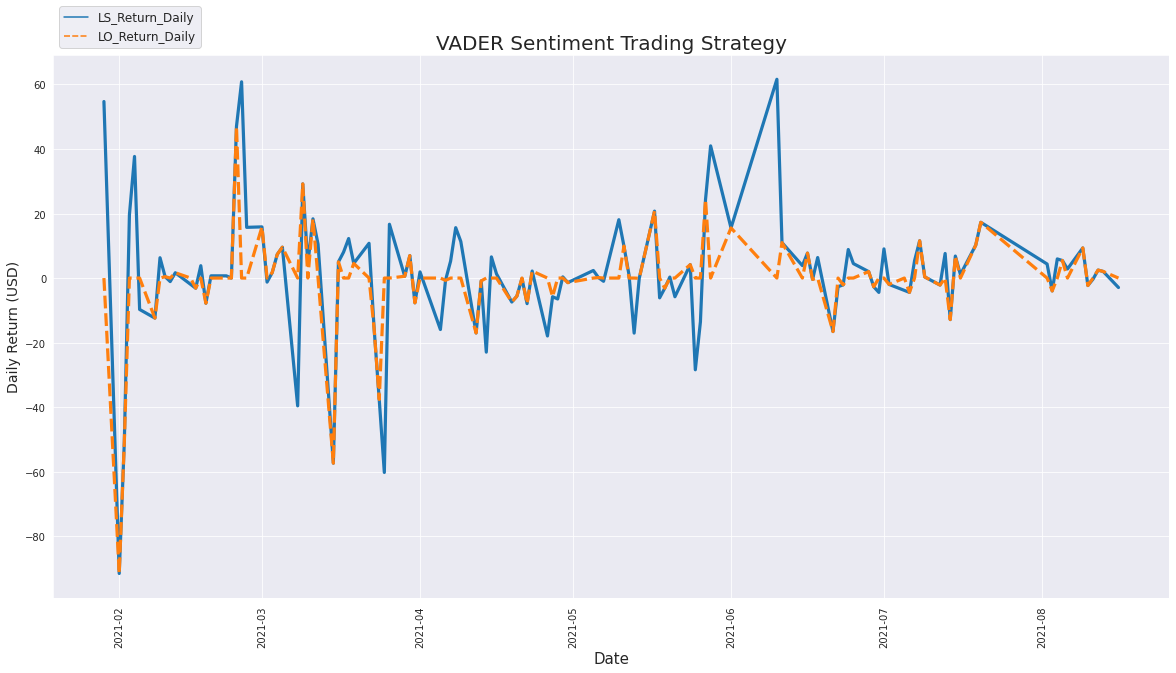

In [ ]:
sentiments['pos_chg'] = sentiments['pos'].pct_change(periods = 1)
sentiments['neg_chg'] = sentiments['neg'].pct_change(periods = 1)


#Create sentiment signals
sentiments['vader_signal'] = np.where(sentiments['pos_chg'] > sentiments['neg_chg'], 1.0, 0.0)

ma_strategy(sentiments, 'vader_signal', "VADER Sentiment Trading Strategy")

### NRC and Vader Combined

In [ ]:
#Generate features from both
sentiments['Sell'] = sentiments['neg'] + sentiments['fear'] + sentiments['anger'] + sentiments['sadness'] + sentiments['disgust']
sentiments['Buy'] = sentiments['pos'] + sentiments['trust'] + sentiments['surprise'] + sentiments['positive'] + sentiments['joy'] + sentiments['anticipation']

sentiments['Buy_chg'] = sentiments['Buy'].pct_change(periods = 1)
sentiments['Sell_chg'] = sentiments['Sell'].pct_change(periods = 1)


#Create sentiment signals
sentiments['sentiment_signal'] = np.where(sentiments['Sell_chg'] > sentiments['Buy_chg'], 1.0, 0.0)

sentiments['Close'] = gm.Close
sentiments ['Open'] = gm.Open
sentiments['daily_return'] = (sentiments.Close - sentiments.Open)


In [ ]:
sentiments['sentiment_signal'].value_counts()

0.0    69
1.0    57
Name: sentiment_signal, dtype: int64

LO Mean Returns: $-0.18
LS Mean Returns: $2.14
LO Cumulative Returns: $-22.14
LS Cumulative Returns: $259.37
Baseline Cumulative Return: $-375.05


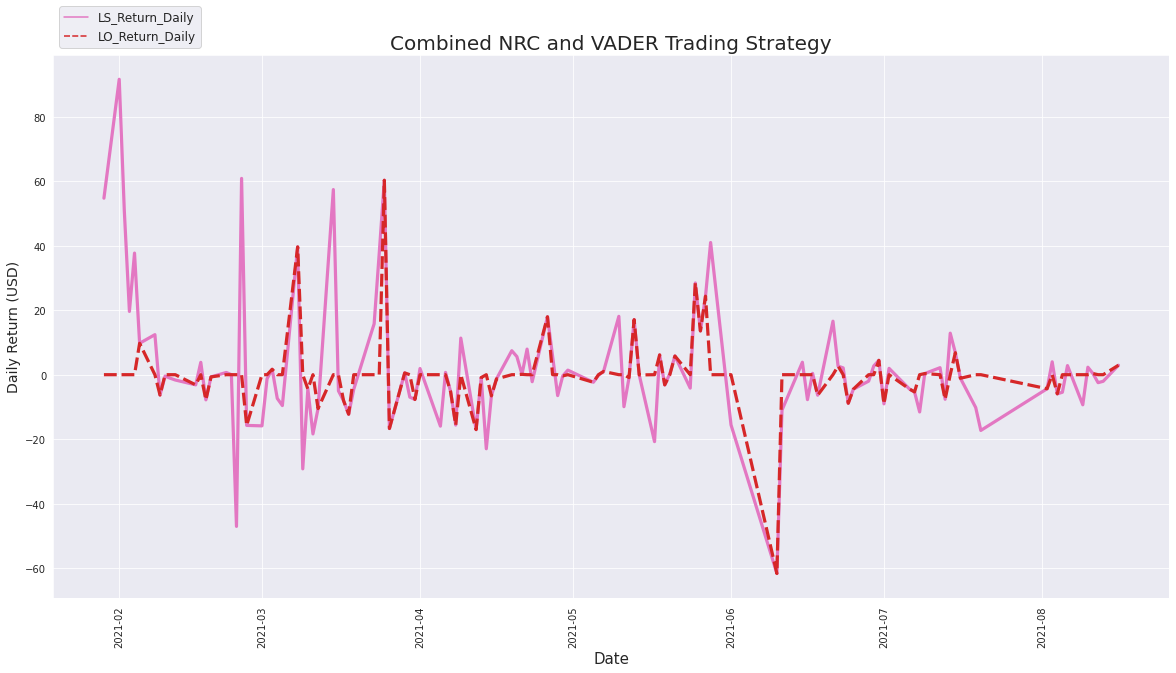

In [ ]:
ma_strategy(sentiments, 'sentiment_signal', 'Combined NRC and VADER Trading Strategy')